# Microsoft Stock Prediction 

- Using historical stock data in combination with aggregated twitter sentiment scores to predict a "buy or sell" signal. 
- TO DO: 
  - Add the rest of the engineered features


In [ ]:
!pip install -q -U keras-tuner

In [ ]:
# Loading required libraries
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras 
from keras.models import Sequential
from keras.losses import BinaryCrossentropy
from keras.layers import Dense, LSTM, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD, Adam, RMSprop
import matplotlib.pyplot  as plt
import kerastuner as kt

pd.set_option("display.max_colwidth" , 100, "display.max_columns", 15)
np.random.seed(12)
tf.random.set_seed(12)


In [ ]:
# Loading Raw Microsoft Stock data containing daily metrics
msft_df = pd.read_csv("https://raw.githubusercontent.com/DDave94/Stock-Prediction-DL/main/datasets/raw/MSFT.csv")

# Loading Twitter Sentiment data containing daily twitter sentiment scores based on daily aggregate tweet analysis
twitter_df = pd.read_csv("https://raw.githubusercontent.com/DDave94/Stock-Prediction-DL/main/datasets/twitter_sentiment_data.csv")

### Feature Engineering
- Generating other prediction metrics such as:
    -  **Moving Average** : A moving average indicates the trend of the price movement and reduced the amount of "noise" on the price chart. We calculate different types of moving averages below. 
    - **Rate Of Change(ROC)**: A measure of the percentage change between the current price and past prices from n days
    - **Momentum** : The rate of acceleration at which the stock price is changing based on historical training data

- Adding Twitter sentiment feature column. The sentiment scores for each day of trading were calculated in a seperate notebook
- Adding target column "signal". For the MSFT stock to have a buy signal on a given day, the short moving average within the last 5 days must be greater than the long moving average in the last 20 days. 

In [ ]:
# Create short simple moving average over the short window of one week
msft_df['short_mavg'] = msft_df['Close'].rolling(window=5, min_periods=1, center=False).mean()

# Create long simple moving average over the long window of four weeks
msft_df['long_mavg'] = msft_df['Close'].rolling(window=20, min_periods=10, center=False).mean()

# Calculation of moving average
def MA(df, n):
    MA = pd.Series(df['Close'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    return MA

msft_df['MA30'] = MA(msft_df, 30)
msft_df['MA90'] = MA(msft_df, 90)

#calculation of exponential moving average
def EMA(df, n):
    EMA = pd.Series(df['Close'].ewm(span=n, min_periods=n).mean(), name='EMA_' + str(n))
    return EMA

msft_df['EMA10'] = EMA(msft_df, 10)
msft_df['EMA30'] = EMA(msft_df, 30)

#calculation of rate of change
def ROC(df, n):  
    M = df.diff(n - 1)  
    N = df.shift(n - 1)  
    ROC = pd.Series(((M / N) * 100), name = 'ROC_' + str(n))   
    return ROC

msft_df['ROC10'] = ROC(msft_df['Close'], 10)
msft_df['ROC30'] = ROC(msft_df['Close'], 30)

#Calculation of price momentum
def MOM(df, n):   
    MOM = pd.Series(df.diff(n), name='Momentum_' + str(n))   
    return MOM

msft_df['MOM10'] = MOM(msft_df['Close'], 10)
msft_df['MOM30'] = MOM(msft_df['Close'], 30)


In [ ]:
# Merging the twitter sentiment scores for each day of stock trading
# This step is only performed when utilizing sentiment for stock signal prediction

msft_df['Date'] = msft_df['Date'].astype(str)
twitter_df['Date'] = twitter_df['Date'].astype(str)

full_data = pd.merge(msft_df,twitter_df, how='inner', on='Date')
full_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,...,EMA10,EMA30,ROC10,ROC30,MOM10,MOM30,TwitterSentiment
0,2017-01-03,62.790001,62.840000,62.130001,62.580002,58.538418,20694100,...,62.759953,61.864946,-1.634701,3.695119,0.280003,1.940003,0.499253
1,2017-01-04,62.480000,62.750000,62.119999,62.299999,58.276497,21340000,...,62.676325,61.893014,-1.951530,2.366083,-1.320000,1.950001,-0.995186
2,2017-01-05,62.189999,62.660000,62.029999,62.299999,58.276497,24876000,...,62.607902,61.919271,-1.951530,1.930628,-1.240002,1.439998,0.318698
3,2017-01-06,62.299999,63.150002,62.040001,62.840000,58.781628,19922900,...,62.650102,61.978673,-1.117229,4.039732,-0.700001,1.720001,-0.348997
4,2017-01-09,62.759998,63.080002,62.540001,62.639999,58.594547,20382700,...,62.648265,62.021339,-0.948771,3.485875,-0.910000,2.239997,-0.074360


In [ ]:
# Create target class which is a buying or selling signal given the stock price movement (SMA vs LMA)
full_data['signal'] = np.where(full_data['short_mavg'] > full_data['long_mavg'], 1.0, 0.0)
full_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,...,EMA30,ROC10,ROC30,MOM10,MOM30,TwitterSentiment,signal
0,2017-01-03,62.790001,62.840000,62.130001,62.580002,58.538418,20694100,...,61.864946,-1.634701,3.695119,0.280003,1.940003,0.499253,1.0
1,2017-01-04,62.480000,62.750000,62.119999,62.299999,58.276497,21340000,...,61.893014,-1.951530,2.366083,-1.320000,1.950001,-0.995186,1.0
2,2017-01-05,62.189999,62.660000,62.029999,62.299999,58.276497,24876000,...,61.919271,-1.951530,1.930628,-1.240002,1.439998,0.318698,0.0
3,2017-01-06,62.299999,63.150002,62.040001,62.840000,58.781628,19922900,...,61.978673,-1.117229,4.039732,-0.700001,1.720001,-0.348997,0.0
4,2017-01-09,62.759998,63.080002,62.540001,62.639999,58.594547,20382700,...,62.021339,-0.948771,3.485875,-0.910000,2.239997,-0.074360,0.0


### Data Preparation 
- Normalizing data using MinMaxScaler()
- Train,Test,Val split 

In [ ]:
# Creating Min Max scaler to scale all features (except date) from 0-1
#scaler = MinMaxScaler(feature_range=(0,1))
scaler = StandardScaler()

temp = full_data.drop(['Date', 'signal'], axis=1)
cols = temp.columns

#Creating scaled data
temp = scaler.fit_transform(temp)

#Generating input_df which will be used for model training and predictions
input_df = pd.concat([full_data['Date'],pd.DataFrame(temp, columns = cols),full_data['signal']], axis=1, ignore_index=False)
print(input_df.shape)
print(input_df.head(5))
#input_df.to_csv('/content/input_df.csv')

(946, 19)
         Date      Open      High       Low     Close  Adj Close    Volume  \
0  2017-01-03 -1.321765 -1.327899 -1.326408 -1.325880  -1.325567 -0.631103   
1  2017-01-04 -1.328279 -1.329763 -1.326622 -1.331759  -1.330957 -0.583943   
2  2017-01-05 -1.334371 -1.331628 -1.328540 -1.331759  -1.330957 -0.325763   
3  2017-01-06 -1.332060 -1.321478 -1.328327 -1.320421  -1.320562 -0.687412   
4  2017-01-09 -1.322396 -1.322928 -1.317670 -1.324621  -1.324412 -0.653840   

   ...     EMA30     ROC10     ROC30     MOM10     MOM30  TwitterSentiment  \
0  ... -1.324668 -0.714598 -0.027702 -0.206077 -0.289512          1.535634   
1  ... -1.324064 -0.793975 -0.245784 -0.454031 -0.288442         -1.155836   
2  ... -1.323500 -0.793975 -0.317238 -0.441633 -0.343058          1.210456   
3  ... -1.322222 -0.584954  0.028846 -0.357949 -0.313072          0.007944   
4  ... -1.321304 -0.542750 -0.062037 -0.390493 -0.257386          0.502563   

   signal  
0     1.0  
1     1.0  
2     0.0  
3   

In [ ]:
# Splitting entire data to create Training and Testing Data
# We will need to split the training and testing data into equivalent 
# time steps to train LSTM Model

# Creating Training and Testing indices
train_data_size = int((0.7)*(input_df.shape[0]))
test_data_size = int(input_df.shape[0] - train_data_size)

# Allocating data instances to training and testing sets
train_data = input_df.iloc[0:train_data_size,1:]
test_data = input_df.iloc[train_data_size:input_df.shape[0],1:]

full_training_data = train_data # Used during model prediction
full_test_data = test_data  # USed during model prediction
print(train_data.head(10))

# Creating numpy arrays from dataframes for future processing
train_data = np.array(train_data)
test_data = np.array(test_data)

print(train_data.shape)
print(test_data.shape)

       Open      High       Low     Close  Adj Close    Volume  short_mavg  \
0 -1.321765 -1.327899 -1.326408 -1.325880  -1.325567 -0.631103   -1.319873   
1 -1.328279 -1.329763 -1.326622 -1.331759  -1.330957 -0.583943   -1.324004   
2 -1.334371 -1.331628 -1.328540 -1.331759  -1.330957 -0.325763   -1.326913   
3 -1.332060 -1.321478 -1.328327 -1.320421  -1.320562 -0.687412   -1.327166   
4 -1.322396 -1.322928 -1.317670 -1.324621  -1.324412 -0.653840   -1.325058   
5 -1.323026 -1.323135 -1.323211 -1.325041  -1.324797 -0.784514   -1.324889   
6 -1.325547 -1.319821 -1.320014 -1.313073  -1.313825 -0.570997   -1.321138   
7 -1.316093 -1.316300 -1.330245 -1.325250  -1.324989 -0.611090   -1.319831   
8 -1.325337 -1.327278 -1.321720 -1.323361  -1.323257 -0.723963   -1.320421   
9 -1.324076 -1.330799 -1.328540 -1.326930  -1.326529 -0.633301   -1.320885   

   ...     EMA30     ROC10     ROC30     MOM10     MOM30  TwitterSentiment  \
0  ... -1.324668 -0.714598 -0.027702 -0.206077 -0.289512       

### Creating Training and Testing Sets

In [ ]:
# Function to create time series data for training and testing
# As an example, this function looks back at five days and adds the 6th day label 
# for X and y respectively.
def create_rolling_data(data, time_step, label_col): 
    X = []
    y = []

    for i in range(time_step, train_data.shape[0]):
        X.append(train_data[i-time_step:i])
        y.append(train_data[i,label_col])
    
    return np.array(X), np.array(y)

time_step = 5
label_col = 17

X_train, y_train = create_rolling_data(train_data, time_step, label_col)

# Gathering the last five days of training data as this will be used to test 
# the first label in y_test
last_5_days = full_training_data.tail()
df = last_5_days.append([full_test_data], ignore_index=True)

X_test, y_test = create_rolling_data(df, time_step, label_col)

### Model Function Definitions
- Creating LSTM model and evaluaperforming hyperparameter tuning 
- Evaluating model by comparing predicted signals against actual signals in testing dataset

In [ ]:
# Model definition
def build_model():

    model = Sequential()

    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
    model.add(Dropout(0.2))

    model.add(LSTM(units = 120, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Dense(units = 1, activation = 'sigmoid'))
   
    print(model.summary())

    return model

# Model Compile
def compile_model(model):
    
    model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

# Model Training
def train_model(model, X_train, Y_train):
    
    batch_size = 32
    epochs = 20
       
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose = 1)

    return model, history

# Model Evaluation and Results Evaluation
def eval_model(model, X_test, y_test):

    y_pred = model.predict(X_test)
    y_pred = y_pred.flatten()
    print(classification_report(y_test.round(), y_pred.round()))


    # Visualising the results
    
    plt.figure(figsize=(14,5))
    plt.plot(y_test, color = 'red', label = 'Actual Buy/Sell Signal ')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Buy/Sell Signal')
    plt.title('MSFT LSTM Stock Buy/Sell Prediction')
    plt.xlabel('Time')
    plt.ylabel('MSFT Stock Signal')
    plt.legend()
    plt.show()
   
    return None


In [ ]:
#Executing functions
model = build_model()
model = compile_model(model)
model, history = train_model(model, X_train, y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 60)             18960     
_________________________________________________________________
dropout (Dropout)            (None, 5, 60)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 60)             29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 60)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 120)               86880     
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1

              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88       180
         1.0       0.94      0.97      0.96       477

    accuracy                           0.94       657
   macro avg       0.93      0.91      0.92       657
weighted avg       0.94      0.94      0.94       657



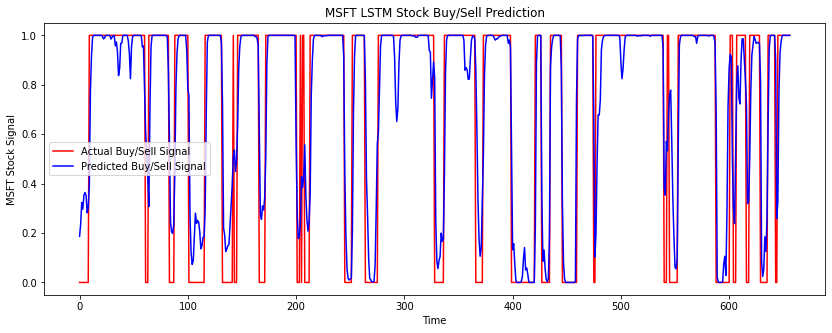

In [ ]:
# Testing Model
eval_model(model, X_test, y_test)

### Hyperparameter Tuning
- Defining function for hyperparameter tuning

In [ ]:
def model_builder(hp):

    #Defining Model 
    hyper_model = Sequential()

    hyper_model.add(LSTM(units = hp.Int('input_layer', 10, 90, step=10), activation = 'relu', 
                         return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    hyper_model.add(Dropout(hp.Choice('Drop1', values = [0.1,0.2,0.3])))

    hyper_model.add(LSTM(units = hp.Int('first_hidden', 10, 90, step=10), 
                         activation = 'relu', return_sequences = True))
    hyper_model.add(Dropout(hp.Choice('Drop2', values = [0.1,0.2,0.3])))
    

    hyper_model.add(LSTM(units = hp.Int('second_hidden', 10, 90, step=10), 
                         activation = 'relu'))
    hyper_model.add(Dropout(hp.Choice('Drop3', values = [0.1,0.2,0.3])))

    hyper_model.add(Dense(units = 1, activation = 'sigmoid'))
        
    hyper_model.compile(optimizer = Adam(learning_rate=hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])),
                        loss = BinaryCrossentropy(), metrics=['accuracy'])
        
    return model


In [ ]:
# Defining Tuner and performing hypertuning
tuner = kt.tuners.randomsearch.RandomSearch(model_builder, objective='accuracy', max_trials=10, seed=42, overwrite = True)

tuner.search(X_train, y_train, epochs=20)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. 
The optimal number of units in the input hidden LSTM layer is {best_hps.get('input_layer')}. 
The optimal amount of dropout in the input LSTM layer is {best_hps.get('Drop1')}. 
The optimal number of units in the first hidden LSTM layer is {best_hps.get('first_hidden')}. 
The optimal amount of dropout in the input LSTM layer is {best_hps.get('Drop2')}. 
The optimal number of units in the second hidden LSTM layer is {best_hps.get('second_hidden')}. 
The optimal amount of dropout in the input LSTM layer is {best_hps.get('Drop3')}. 
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")

Trial 10 Complete [00h 00m 10s]
accuracy: 1.0

Best accuracy So Far: 1.0
Total elapsed time: 00h 01m 42s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. 
The optimal number of units in the input hidden LSTM layer is 70. 
The optimal amount of dropout in the input LSTM layer is 0.1. 
The optimal number of units in the first hidden LSTM layer is 70. 
The optimal amount of dropout in the input LSTM layer is 0.1. 
The optimal number of units in the second hidden LSTM layer is 40. 
The optimal amount of dropout in the input LSTM layer is 0.1. 
The optimal learning rate for the optimizer is 0.01.



#### Evaluating Model created using optimal values for hyperparameters and number of epochs
- In Step One, we create the model using the best hyperparameter values identified during tuning. Then we find the epoch in which we obtain the best accuracy. 

- In Step Two, we recreate the model using the optimal hyperparameter values and the ideal number of training epochs. Then we evaluate the model again to compare results against the first non-tuned model with random parameters

In [ ]:
#Step One
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20)

acc_per_epoch = history.history['accuracy']
best_epoch = acc_per_epoch.index(max(acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/20
21/21 [==============================] - 1s 24ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 2/20
21/21 [==============================] - 1s 24ms/step - loss: 0.0171 - accuracy: 0.9954
Epoch 3/20
21/21 [==============================] - 1s 24ms/step - loss: 0.0130 - accuracy: 0.9924
Epoch 4/20
21/21 [==============================] - 0s 23ms/step - loss: 0.0044 - accuracy: 1.0000
Epoch 5/20
21/21 [==============================] - 0s 23ms/step - loss: 7.4534e-04 - accuracy: 1.0000
Epoch 6/20
21/21 [==============================] - 0s 23ms/step - loss: 0.0033 - accuracy: 0.9985
Epoch 7/20
21/21 [==============================] - 1s 25ms/step - loss: 0.0099 - accuracy: 0.9970
Epoch 8/20
21/21 [==============================] - 0s 24ms/step - loss: 0.0809 - accuracy: 0.9787
Epoch 9/20
21/21 [==============================] - 0s 22ms/step - loss: 0.0264 - accuracy: 0.9878
Epoch 10/20
21/21 [==============================] - 0s 23ms/step - loss: 0.0492 - accuracy: 0.9802
Epoch

In [ ]:
#Step Two
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch)

21/21 [==============================] - 0s 23ms/step - loss: 0.0026 - accuracy: 1.0000


21/21 [==============================] - 0s 4ms/step - loss: 8.8276e-04 - accuracy: 1.0000
[test loss, test accuracy]: [0.0008827605633996427, 1.0]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       180
         1.0       1.00      1.00      1.00       477

    accuracy                           1.00       657
   macro avg       1.00      1.00      1.00       657
weighted avg       1.00      1.00      1.00       657



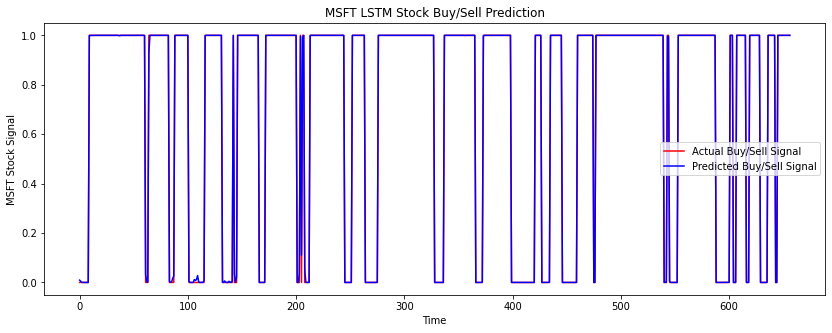

In [ ]:
#Hyper Parameter Model Evaluation
eval_result = hypermodel.evaluate(X_test, y_test)
print("[test loss, test accuracy]:", eval_result)

eval_model(hypermodel, X_test, y_test)